In [23]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# load iris data
iris = datasets.load_iris()

# use only 2 features
X = iris.data[:, [2, 3]]

y = iris.target
print('Class labels:', np.unique(y))


Class labels: [0 1 2]


In [3]:
# split into train and test set, with same ratio of classes as the full dataset in each set (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [4]:
# standardize features
sc = StandardScaler()

# fit the standard scaler on the train set
sc.fit(X_train)

# then use it to transform both train and test set
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Perceptron

In [5]:
# train
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [6]:
# eval on test set
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Misclassified examples: 1
Accuracy: 0.978


In [7]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

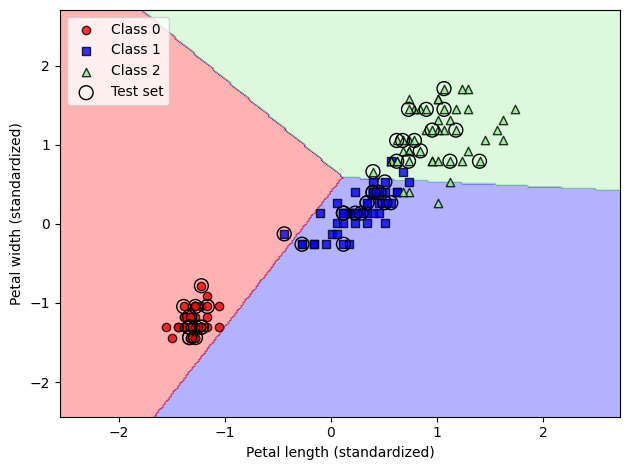

In [8]:
# combine the tests set back for plotting
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined, ppn, test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Logistic Regression

In [9]:
class LogisticRegressionGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta                      # learning rate
        self.n_iter = n_iter                # number of iterations on dataset
        self.random_state = random_state    # random generator key

    def fit(self, X, y):
         # generate random weights, size is same as number of features
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])

        # init bias to 0
        self.b_ = np.float_(0.)

        self.losses_ = []

         # iterate over dataset n_iter times
        for _ in range(self.n_iter):
            # calculate input for activation function
            net_input = self.net_input(X)
            # feed to activation function
            output = self.activation(net_input)
            # error = y_true - activation function output
            errors = y - output

            # update weights
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            # update bias
            self.b_ += self.eta * 2.0 * errors.mean()

            # MSE loss
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        
        return self

    def net_input(self, X):
        # z = wTx + b
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        # logistic regression uses the sigmoid function
        return 1. / (1 + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        # if output of sigmoid function >= 0.5, return 1, else 0
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

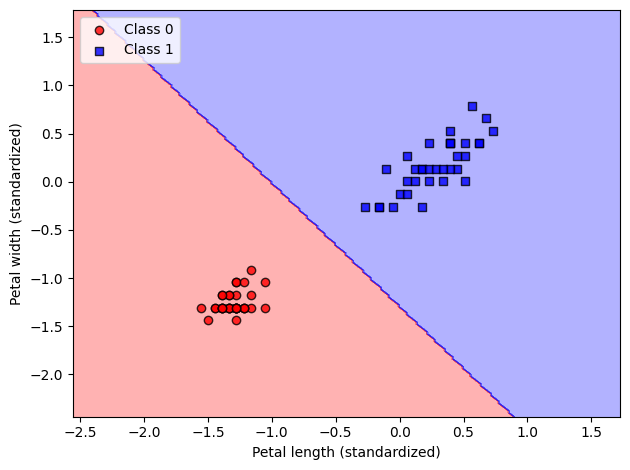

In [10]:
# logistic regression is for binary classification, so only use two classes in the dataset
X_train_two_class_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_two_class_subset = y_train[(y_train == 0) | (y_train == 1)]

# train
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_two_class_subset, y_train_two_class_subset)

# plot
plot_decision_regions(X_train_two_class_subset, y_train_two_class_subset, lrgd)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

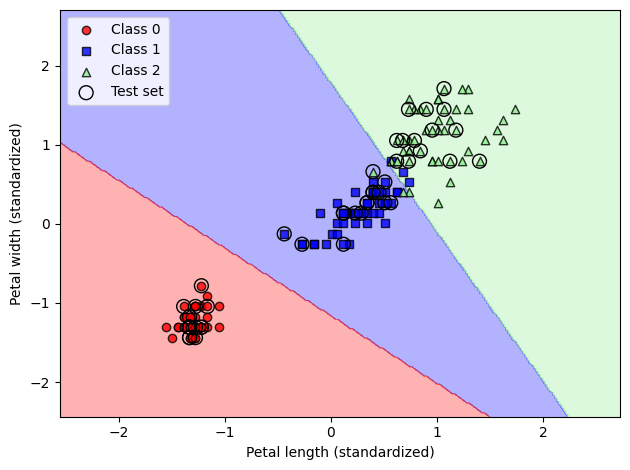

In [11]:
# Logistic regression in sklearn uses multinomial for multiclass classification
# lbfgs is more advanced than GD or SGD, and is recommended for minimizing convex cost function such as the one for logistic regression
# C is the regularization parameter; more C = less regularization, vice versa
lr = LogisticRegression(C=100.0, solver='lbfgs',multi_class='multinomial')
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
# predict the probability of the first 3 samples to each 3 classes
lr.predict_proba(X_test_std[:3, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

In [13]:
# predict the class of the first 3 samples
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

# SVM

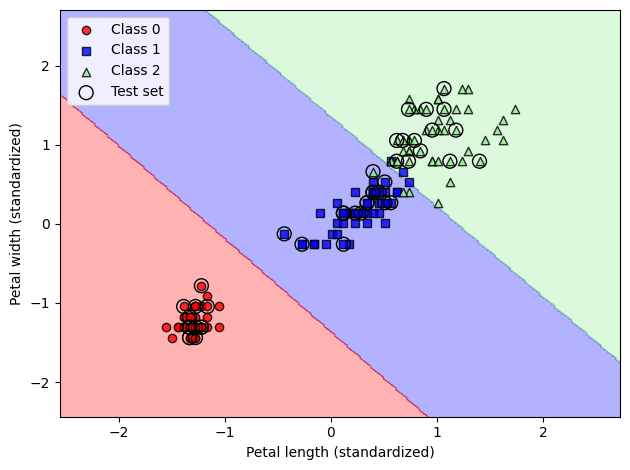

In [14]:
# C is hyperparameter for penalty of misclassification, more C = more error penalty (less regularization), vice versa 
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

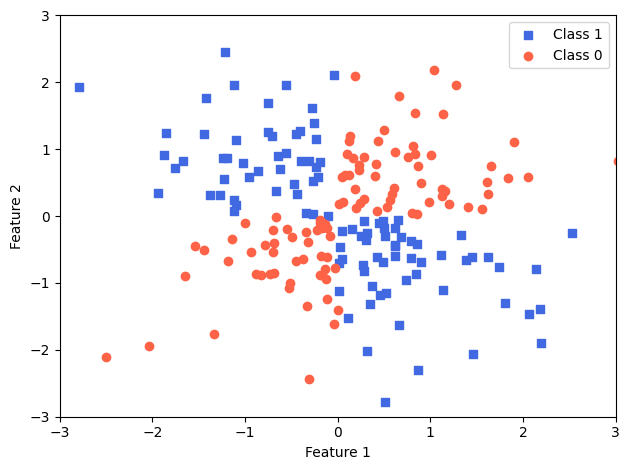

In [15]:
# create a nonlinear separable data to illustrate that kernel SVM can solve nonlinear classification
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o', label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

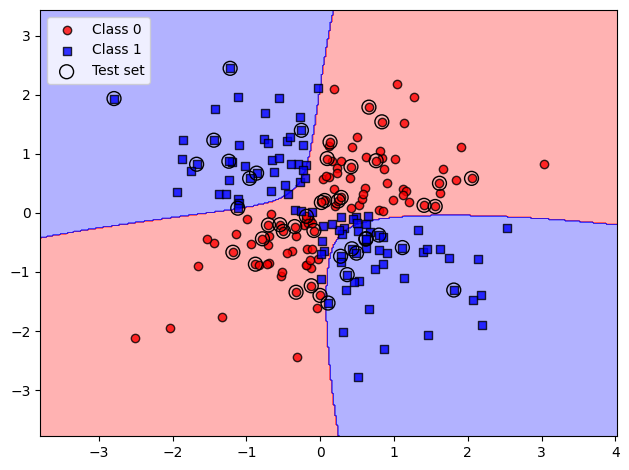

In [16]:
# rbf is a popular kernel for nonlinear classification
# gamma is a tunning parameter, greater gamma = more influence of each sample = more fit decision boundary
svm = SVC(kernel='rbf', C=10.0, random_state=1, gamma=0.1)
svm.fit(X_xor, y_xor)

plot_decision_regions(X_xor, y_xor, classifier=svm, test_idx=range(105, 150))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

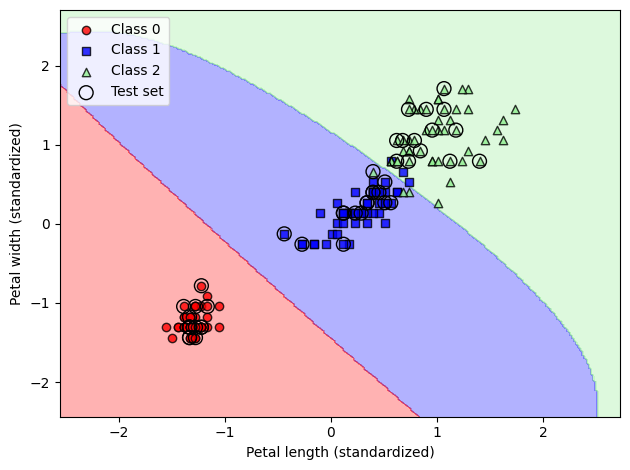

In [17]:
# less gamma = more general boundary
svm = SVC(kernel='rbf', C=1.0, random_state=1, gamma=0.2)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

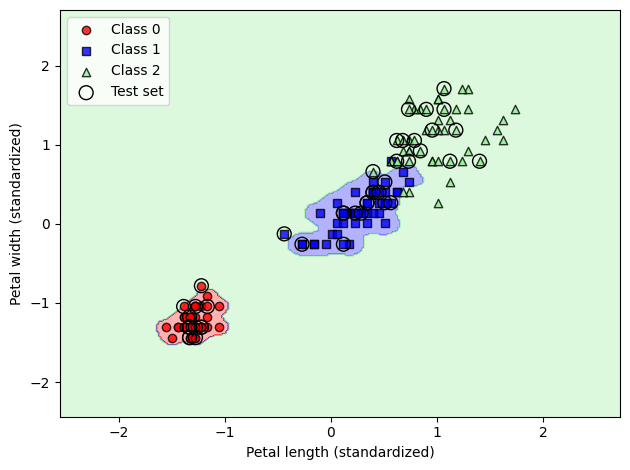

In [18]:
# greater gamma might overfit
svm = SVC(kernel='rbf', C=1.0, random_state=1, gamma=100.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Tree

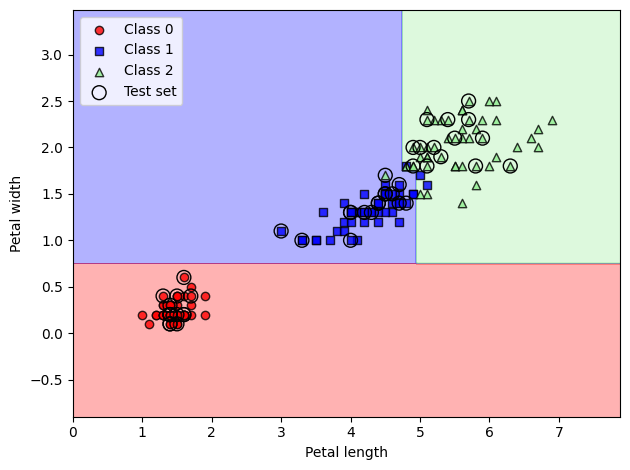

In [19]:
# criterion sets the method to measure the quality of split on node
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
# tree classifier does not need feature standardization
tree_model.fit(X_train, y_train)

# combine dataset for plotting
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105, 150))
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

[Text(0.25, 0.9, 'Sepal width <= 0.75\ngini = 0.667\nsamples = 105\nvalue = [35, 35, 35]'),
 Text(0.125, 0.7, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]'),
 Text(0.375, 0.7, 'Sepal length <= 4.75\ngini = 0.5\nsamples = 70\nvalue = [0, 35, 35]'),
 Text(0.25, 0.5, 'gini = 0.0\nsamples = 30\nvalue = [0, 30, 0]'),
 Text(0.5, 0.5, 'Sepal width <= 1.75\ngini = 0.219\nsamples = 40\nvalue = [0, 5, 35]'),
 Text(0.25, 0.3, 'Sepal length <= 4.95\ngini = 0.5\nsamples = 8\nvalue = [0, 4, 4]'),
 Text(0.125, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.375, 0.1, 'gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.75, 0.3, 'Sepal length <= 4.85\ngini = 0.061\nsamples = 32\nvalue = [0, 1, 31]'),
 Text(0.625, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(0.875, 0.1, 'gini = 0.0\nsamples = 29\nvalue = [0, 0, 29]')]

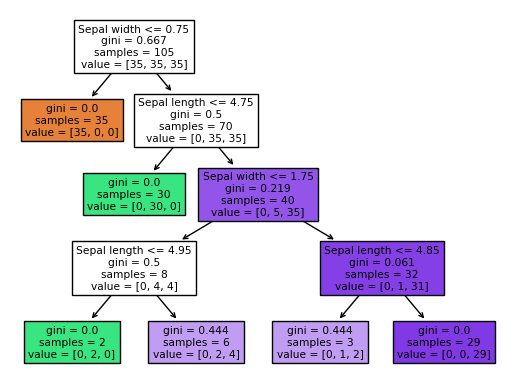

In [20]:
# visualize the tree
feature_names = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
tree.plot_tree(tree_model, feature_names=feature_names, filled=True)

# Random Forest

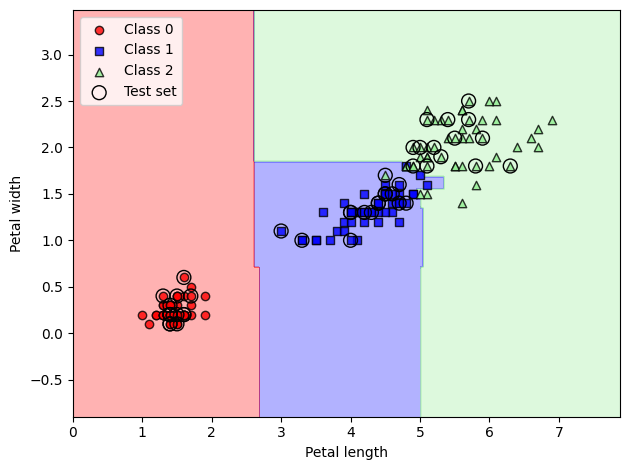

In [22]:
forest = RandomForestClassifier(n_estimators=25, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# KNN

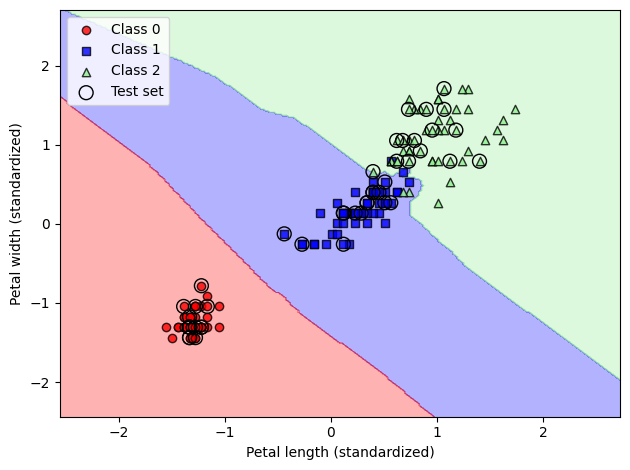

In [25]:
# metric = minkowski and p=2 means using Euclidean distance
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()